## 초기 데이터
- GDP : 미국, 영국, 유로존, 일본, 한국
- 국채금리 : 독일, 미국, 일본, 프랑스, 한국 각 1, 2, 3년 데이터
- 소비자 물가 지수 : 미국, 영국, 유로존, 한국(일본은 데이터가 상당히 부족해 제거)
- 소비자 신뢰 지수 : 미국, 영국, 유로존, 일본, 한국
- 실업률 : 미국, 영국, 유로존, 일본, 한국
- 환율 : KRW/USD, KRW/EUR, KRW/GBP, KRW/JPY, EUR/USD, GBP/USD, JPY/USD 
- 유명 주가지수 : JASDAQ, TOPIX, Nikkei, 독일 DAX, 독일 MDAX, 독일 TecDAX, S&P500, NASDAQ, Dow Jones, 영국 FTSE,  EURO STOXX 50, KOSDAQ, KOSPI 200, KOSPI, 프랑스 CAC 40, 프랑스 CAC Next 20, 프랑스 SBF 120

In [4]:
# pakages
import os
import pandas as pd
import glob
import numpy as np
# import datetime
from datetime import date, datetime
import warnings

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error

from dateutil.relativedelta import relativedelta
from pytimekr import pytimekr
import random
from itertools import combinations
from dtaidistance import dtw

numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


## 데이터 불러오기

- 주가 지수 통합

In [ ]:
data_folder = os.path.join(base_path, 'data', '나라별 3대 주가지수')

# 데이터 파일 경로 설정 및 불러오기
def read_csv_file(filename):
    file_path = os.path.join(data_folder, filename)
    return pd.read_csv(file_path)

germany_DAX = read_csv_file('독일 DAX 과거 데이터.csv')
germany_MDAX = read_csv_file('독일 MDAX 과거 데이터.csv')
germany_TecDAX = read_csv_file('독일 TecDAX 과거 데이터.csv')
usa_SP500 = read_csv_file('미국 s&p 500(SPY) 과거 데이터 (1).csv')
usa_NASDAQ = read_csv_file('미국 나스닥종합지수 과거데이터.csv')
usa_DOW = read_csv_file('미국 다우존스 과거 데이터.csv')
euro_STOCKS50 = read_csv_file('유로 스톡스 50 과거 데이터.csv')
japan_JASDAQ20 = read_csv_file('일본 JASDAQ 20 과거 데이터.csv')
japan_TOPIX = read_csv_file('일본 TOPIX 과거 데이터.csv')
japan_NIKKEI = read_csv_file('일본 닛케이 과거 데이터.csv')
france_CAC = read_csv_file('프CAC 40 Historical Data.csv')
france_CACNEXT = read_csv_file('프CAC Next 20 Historical Data.csv')
france_SBF = read_csv_file('프SBF 120 Historical Data.csv')
korea_KOSDAQ = read_csv_file('한국 코스닥 과거 데이터.csv')
korea_KOSPI200 = read_csv_file('한국 코스피 200 과거 데이터.csv')
korea_KOSPI = read_csv_file('한국 코스피지수 과거 데이터.csv')
uk_FTSE = read_csv_file('영국 FTSE 과거 데이터.csv')
uk_FTSE250 = read_csv_file('영국 FTSE 250 TR 과거 데이터.csv')
uk_FTSEALL = read_csv_file('영국 FTSE All-Share Historical Data.csv')

france_CAC.rename(columns={'Date': '날짜'}, inplace=True)
france_CACNEXT.rename(columns={'Date': '날짜'}, inplace=True)
france_SBF.rename(columns={'Date': '날짜'}, inplace=True)
uk_FTSEALL.rename(columns={'Date': '날짜'}, inplace=True)

germany_DAX.rename(columns={'종가': 'Germany_DAX_Close', '시가': 'Germany_DAX_Open', '고가': 'Germany_DAX_High', '저가': 'Germany_DAX_Low'}, inplace=True)
germany_MDAX.rename(columns={'종가': 'Germany_MDAX_Close', '시가': 'Germany_MDAX_Open', '고가': 'Germany_MDAX_High', '저가': 'Germany_MDAX_Low'}, inplace=True)
germany_TecDAX.rename(columns={'종가': 'Germany_TecDAX_Close', '시가': 'Germany_TecDAX_Open', '고가': 'Germany_TecDAX_High', '저가': 'Germany_TecDAX_Low'}, inplace=True)
usa_SP500.rename(columns={'종가': 'USA_SP500_Close', '시가': 'USA_SP500_Open', '고가': 'USA_SP500_High', '저가': 'USA_SP500_Low'}, inplace=True)
usa_NASDAQ.rename(columns={'종가': 'USA_NASDAQ_Close', '시가': 'USA_NASDAQ_Open', '고가': 'USA_NASDAQ_High', '저가': 'USA_NASDAQ_Low'}, inplace=True)
usa_DOW.rename(columns={'종가': 'USA_DOW_Close', '시가': 'USA_DOW_Open', '고가': 'USA_DOW_High', '저가': 'USA_DOW_Low'}, inplace=True)
euro_STOCKS50.rename(columns={'종가': 'Euro_STOCKS50_Close', '시가': 'Euro_STOCKS50_Open', '고가': 'Euro_STOCKS50_High', '저가': 'Euro_STOCKS50_Low'}, inplace=True)
japan_JASDAQ20.rename(columns={'종가': 'Japan_JASDAQ20_Close', '시가': 'Japan_JASDAQ20_Open', '고가': 'Japan_JASDAQ20_High', '저가': 'Japan_JASDAQ20_Low'}, inplace=True)
japan_TOPIX.rename(columns={'종가': 'Japan_TOPIX_Close', '시가': 'Japan_TOPIX_Open', '고가': 'Japan_TOPIX_High', '저가': 'Japan_TOPIX_Low'}, inplace=True)
japan_NIKKEI.rename(columns={'종가': 'Japan_NIKKEI_Close', '시가': 'Japan_NIKKEI_Open', '고가': 'Japan_NIKKEI_High', '저가': 'Japan_NIKKEI_Low'}, inplace=True)
korea_KOSDAQ.rename(columns={'종가': 'Korea_KOSDAQ_Close', '시가': 'Korea_KOSDAQ_Open', '고가': 'Korea_KOSDAQ_High', '저가': 'Korea_KOSDAQ_Low'}, inplace=True)
korea_KOSPI200.rename(columns={'종가': 'Korea_KOSPI200_Close', '시가': 'Korea_KOSPI200_Open', '고가': 'Korea_KOSPI200_High', '저가': 'Korea_KOSPI200_Low'}, inplace=True)
korea_KOSPI.rename(columns={'종가': 'Korea_KOSPI_Close', '시가': 'Korea_KOSPI_Open', '고가': 'Korea_KOSPI_High', '저가': 'Korea_KOSPI_Low'}, inplace=True)
france_CAC.rename(columns={'Price': 'France_CAC_Close', 'Open': 'France_CAC_Open', 'High': 'France_CAC_High', 'Low': 'France_CAC_Low'}, inplace=True)
france_CACNEXT.rename(columns={'Price': 'France_CACNEXT_Close', 'Open': 'France_CACNEXT_Open', 'High': 'France_CACNEXT_High', 'Low': 'France_CACNEXT_Low'}, inplace=True)
france_SBF.rename(columns={'Price': 'France_SBF_Close', 'Open': 'France_SBF_Open', 'High': 'France_SBF_High', 'Low': 'France_SBF_Low'}, inplace=True)
uk_FTSE.rename(columns={'종가': 'UK_FTSE_Close', '시가': 'UK_FTSE_Open', '고가': 'UK_FTSE_High', '저가': 'UK_FTSE_Low'}, inplace=True)
uk_FTSE250.rename(columns={'종가': 'UK_FTSE250_Close', '시가': 'UK_FTSEU250_Open', '고가': 'UK_FTSE250_High', '저가': 'UK_FTSE250_Low'}, inplace=True)
uk_FTSEALL.rename(columns={'Price': 'UK_FTSEALL_Close', 'Open': 'UK_FTSEALL_Open', 'High': 'UK_FTSEALLHigh', 'Low': 'UK_FTSEALL_Low'}, inplace=True)

stock_list = [germany_DAX, germany_MDAX, germany_TecDAX, usa_SP500, usa_NASDAQ, usa_DOW, euro_STOCKS50, japan_JASDAQ20, japan_TOPIX, japan_NIKKEI, france_CAC, france_CACNEXT, france_SBF, korea_KOSDAQ, korea_KOSPI200, korea_KOSPI, uk_FTSE, uk_FTSE250, uk_FTSEALL]

for data in stock_list:
    data['날짜'] = pd.to_datetime(data['날짜'])
    data.drop(data.columns[[5, 6]], axis=1, inplace=True)
    
# 날짜 범위를 기준으로 DataFrame 생성
merged_stock = pd.DataFrame(date_range, columns=['날짜'])

# 각 DataFrame의 '날짜' 열을 datetime64[ns]로 변환
for df in stock_list:
    df['날짜'] = pd.to_datetime(df['날짜'])

# 각 DataFrame을 생성된 날짜 범위를 기준으로 병합
for df in stock_list:
    merged_stock = merged_stock.merge(df, on='날짜', how='left')
    
merged_stock = merged_stock.sort_values(by='날짜', ascending=False).reset_index(drop=True)
merged_stock.to_csv('유명주가지수 통합.csv', index=False, encoding='utf-8-sig')

- 환율

In [ ]:
file_list = os.listdir(os.path.dirname(os.getcwd())+ "\\사용data\\환율\\")
for file in file_list:
    data = pd.read_csv(dir + file)
    data = data[["날짜","종가","시가","고가","저가"]]
    data.columns = ["Date",file[0:7] + "_Close", file[0:7] + "_Open", file[0:7] + "_High", file[0:7] + "_Low"]
    data.Date = list(map(lambda x : datetime.datetime.strptime(x, "%Y- %m- %d").strftime('%Y-%m-%d'), data.Date))
    data.to_csv(os.path.dirname(os.getcwd())+ "\\사용data\\환율\\" + file, index=False)

- GDP, 소비자물가지수, 소비자신뢰지수, 실업률

In [6]:
folder_list = os.listdir(os.path.dirname(os.getcwd())+ "\\사용data")
folder_list.remove("국채금리")
folder_list.remove("환율")
folder_list

['GDP', '소비자물가지수', '소비자신뢰지수', '실업률']

In [ ]:
foler_list = os.listdir(os.path.dirname(os.getcwd())+ "\\사용data")
file_list = []
for folder in folder_list:
    f_list = os.listdir(os.path.dirname(os.getcwd())+ "\\사용data\\" + folder)
    f_list = list(map(lambda x: os.path.dirname(os.getcwd())+ "\\사용data\\"+ folder + "\\" + x , f_list))
    file_list.append(f_list)
file_list = sum(file_list, [])
for file in file_list:
    data = pd.read_excel(file, header = None)
    data.loc[:,0] = list(map(lambda x : datetime.datetime.strptime(x[0:13], "%Y년 %m월 %d일").strftime('%Y-%m-%d') if type(x) == str else (datetime.date(1899,12,30) + datetime.timedelta(int(x))).strftime('%Y-%m-%d'), data.loc[:,0]))
    data.loc[:,1] = list(map(lambda x : x.strftime('%H:%M') if type(x) == datetime.time else x[0:5], data.loc[:,1]))
    data.to_excel(file, index=False, header=False)

- 국채금리

In [ ]:
file_list = os.listdir(os.path.dirname(os.getcwd())+ "\\사용data\\국채금리\\")
for file in file_list:
    data = pd.read_csv(os.path.dirname(os.getcwd())+ "\\사용data\\국채금리\\" + file)
    data.iloc[:,0] = list(map(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d").strftime('%Y-%m-%d'), data.iloc[:,0]))
    data.to_csv(os.path.dirname(os.getcwd())+ "\\사용data\\국채금리\\" + file, index=False)

## 전체 데이터 통합

In [14]:
GDP = pd.DataFrame(columns=['Date'])
dir = os.path.dirname(os.getcwd())+ "\\사용data\\GDP\\"
file_list = os.listdir(dir)
for file in file_list:
    data = pd.read_excel(dir + file, header = None)
    data = data[[0,2]]
    data.columns = ["Date", file[0:len(file)-5] + "_GDP"]
    GDP = pd.merge(GDP, data, how='outer',on='Date')
    
Treasury_rate = pd.DataFrame(columns=['Date'])
dir = os.path.dirname(os.getcwd())+ "\\사용data\\국채금리\\"
file_list = os.listdir(dir)
for file in file_list:
    data = pd.read_csv(dir + file)
    data.iloc[:,5] = data.iloc[:,5].apply(lambda x: x.replace("%",""))
    data.iloc[:,5] = data.iloc[:,5].apply(lambda x: float(x.replace(",","")))
    data.columns = ["Date", file[0:len(file)-11] + "_Price", file[0:len(file)-10] + "_Open", file[0:len(file)-11] + "_High", file[0:len(file)-11] + "_Low", file[0:len(file)-11] + "_Change"]
    Treasury_rate = pd.merge(Treasury_rate, data, how='outer',on='Date')
    
CPI = pd.DataFrame(columns=['Date'])
dir = os.path.dirname(os.getcwd())+ "\\사용data\\소비자물가지수\\"
file_list = os.listdir(dir)
file_list

for file in file_list:
    data = pd.read_excel(dir + file, header = None)
    data = data[[0,2]]
    data.columns = ["Date", file[0:len(file)-5] + "_CPI"]
    CPI = pd.merge(CPI, data, how='outer',on='Date')
    
CCI = pd.DataFrame(columns=['Date'])
dir = os.path.dirname(os.getcwd())+ "\\사용data\\소비자신뢰지수\\"
file_list = os.listdir(dir)
for file in file_list:
    data = pd.read_excel(dir + file, header = None)
    data = data[[0,2]]
    data.columns = ["Date", file[0:len(file)-5] + "_CCI"]
    CCI = pd.merge(CCI, data, how='outer',on='Date')
                         
Unemployment_Rate = pd.DataFrame(columns=['Date'])
dir = os.path.dirname(os.getcwd())+ "\\사용data\\실업률\\"
file_list = os.listdir(dir)
for file in file_list:
    data = pd.read_excel(dir + file, header = None)
    data = data[[0,2]]
    data.columns = ["Date", file[0:len(file)-9] + "_Unemploy"]
    Unemployment_Rate = pd.merge(Unemployment_Rate, data, how='outer',on='Date')

Exchange_Rate = pd.DataFrame(columns=['Date'])
dir = os.path.dirname(os.getcwd())+ "\\사용data\\환율\\"
file_list = os.listdir(dir)
for file in file_list:
    data = pd.read_csv(dir + file)
    data.iloc[:,1] = data.iloc[:,1].apply(lambda x: float(x.replace(",","") if type(x) == str else x))
    data.iloc[:,2] = data.iloc[:,2].apply(lambda x: float(x.replace(",","") if type(x) == str else x))
    data.iloc[:,3] = data.iloc[:,3].apply(lambda x: float(x.replace(",","") if type(x) == str else x))
    data.iloc[:,4] = data.iloc[:,4].apply(lambda x: float(x.replace(",","") if type(x) == str else x))
    Exchange_Rate = pd.merge(Exchange_Rate, data, how='outer',on='Date')

Stock_Price = pd.read_csv(os.path.dirname(os.getcwd())+ "\\data\\유명 주가지수\\"+"유명주가지수 통합.csv")
Stock_Price = Stock_Price.rename(columns={'날짜':'Date'})
Stock_Price[Stock_Price.columns.difference(['Date'])] = Stock_Price[Stock_Price.columns.difference(['Date'])].applymap(lambda x: float(x.replace(",","")) if type(x)==str else x)

Data_name = [GDP, Treasury_rate, CPI, CCI, Unemployment_Rate, Stock_Price, Exchange_Rate]
Total = pd.DataFrame(columns=['Date'])
for data in Data_name:
    Total = pd.merge(Total, data, how='outer',on='Date')

## 스플라인 보간, 데이터 발표일 변수 생성

- 기간 : 2013년 1월 1일부터 2022년 12월 30일까지
- 월별, 분기별 데이터 : None은 스플라인 보간법으로 값을 채움, 데이터 발표일 변수 생성

In [15]:
warnings.filterwarnings(action='ignore')

# 시간 순 정렬, 기간에 맞는 데이터 추출
Total = Total.sort_values(by=['Date'], axis=0)
Total = Total.reset_index(drop=True)

# 스플라인 보간
Total[Total.columns.difference(['Date'])] = Total[Total.columns.difference(['Date'])].interpolate(method='cubic',axis=0)
Total = Total[("2013-01-01" <= Total.Date) & (Total.Date < "2022-12-31")]

# 실업률, CPI, CCI, GDP의 발표날 columns
columns = GDP.columns.difference(["Date"]).tolist() + CPI.columns.difference(["Date"]).tolist() \
    + CCI.columns.difference(["Date"]).tolist() + Unemployment_Rate.columns.difference(["Date"]).tolist()

Ann = []
for column in columns:
    Ann += [column + "_Ann"]
    Total[[column + "_Ann"]] = 0
    Total[column + "_Ann"][Total[[column]].dropna().index]=1

warnings.filterwarnings(action='default')

In [5]:
Total = pd.read_csv(r'C:\Users\choi\Desktop\확인용\Total.csv')

In [6]:
Total

,Date,미국_GDP,영국_GDP,유로존_GDP,일본_GDP,한국_GDP,독일 1년_Price,독일 1년_Open,독일 1년_High,독일 1년_Low,...,미국_CCI_Ann,영국_CCI_Ann,유로존_CCI_Ann,일본_CCI_Ann,한국_CCI_Ann,미국_Unemploy_Ann,영국_Unemploy_Ann,유로존_Unemploy_Ann,일본_Unemploy_Ann,한국_Unemploy_Ann
0,2013-01-01,0.021704,0.005970,-0.000403,-0.006134,0.003276,0.124000,0.124000,0.12400,0.124000,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,0.020080,0.005294,-0.000442,-0.005869,0.003395,0.050000,0.024000,0.10800,0.018000,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,0.018531,0.004650,-0.000492,-0.005615,0.003504,0.052000,0.019000,0.11300,0.018000,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,0.017054,0.004037,-0.000553,-0.005370,0.003604,0.067000,0.027000,0.07800,0.023000,...,0,0,0,0,0,1,0,0,0,0
4,2013-01-05,0.015649,0.003454,-0.000624,-0.005134,0.003695,0.028000,0.131000,0.13100,0.028000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,2022-12-26,0.032274,-0.002860,0.003601,-0.000238,0.000441,2.630408,2.543491,2.61119,2.560452,...,0,0,0,0,0,0,0,0,0,0
3648,2022-12-27,0.032300,-0.002820,0.003609,-0.000145,0.000298,2.624000,2.581000,2.62400,2.532000,...,0,0,0,0,1,0,0,0,1,0
3649,2022-12-28,0.032310,-0.002779,0.003614,-0.000052,0.000152,2.605000,2.601000,2.63900,2.520000,...,0,0,0,0,0,0,0,0,0,0
3650,2022-12-29,0.032305,-0.002736,0.003615,0.000039,0.000006,2.549000,2.619000,2.61900,2.527000,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# None 값 없음
Total.isnull().sum().sort_values(axis=0)

Date                  0
China_SANGHAI_High    0
China_SANGHAI_Low     0
France_CAC_Close      0
France_CAC_Open       0
                     ..
한국 2년_Change          0
한국 3년_Price           0
한국 3년_Open            0
프랑스 3년_Low            0
한국_Unemploy_Ann       0
Length: 255, dtype: int64

- 고가, 저가, 시가, 국채금리 1년, 2년 데이터 제거 : 다중공선성 문제

In [8]:
categorical = ['미국_GDP_Ann', '영국_GDP_Ann', '유로존_GDP_Ann', '일본_GDP_Ann', '한국_GDP_Ann', '미국_CPI_Ann', '영국_CPI_Ann', 
            '유로존_CPI_Ann', '한국_CPI_Ann', '미국_CCI_Ann', '영국_CCI_Ann', '유로존_CCI_Ann', '일본_CCI_Ann', '한국_CCI_Ann', 
            '미국_Unemploy_Ann', '영국_Unemploy_Ann', '유로존_Unemploy_Ann', '일본_Unemploy_Ann', '한국_Unemploy_Ann']

GDP = [ '미국_GDP', '영국_GDP', '유로존_GDP', '일본_GDP', '한국_GDP']
Treasury_rate  = ['독일 2년_Price', '미국 2년_Price', '일본 2년_Price', '프랑스 2년_Price', '한국 2년_Price']
CPI = ['미국_CPI', '영국_CPI', '유로존_CPI', '한국_CPI']
CCI = ['미국_CCI', '영국_CCI', '유로존_CCI', '일본_CCI', '한국_CCI']
Unemployment_Rate = ['미국_Unemploy', '영국_Unemploy', '유로존_Unemploy', '일본_Unemploy', '한국_Unemploy']
Stock_Price = ['Germany_DAX_Close', 'Germany_MDAX_Close', 'Germany_TecDAX_Close', 'USA_SP500_Close', 'USA_NASDAQ_Close', 'USA_DOW_Close', 'Euro_STOCKS50_Close', 'Japan_JASDAQ20_Close', 
               'Japan_TOPIX_Close', 'Japan_NIKKEI_Close', 'France_CAC_Close', 'France_CACNEXT_Close', 'France_SBF_Close',
               'Korea_KOSDAQ_Close', 'Korea_KOSPI200_Close', 'Korea_KOSPI_Close', 'UK_FTSE_Close', 'UK_FTSE250_Close', 'UK_FTSEALL_Close']
Exchange_Rate = ['KRWEUR_Close', 'KRWGBP_Close', 'KRWJPY_Close', 'KRWUSD_Close', 'EURUSD_Close', 'GBPUSD_Close', 'JPYUSD_Close']
quantitative = GDP + Treasury_rate + CPI + CCI + Unemployment_Rate + Stock_Price + Exchange_Rate


Total = Total[quantitative + categorical]

## 이상치 제거

- 모든 데이터에 대한 그래프를 확인해본 결과, 측정값을 잘못 입력하거나 측정을 잘못한 것으로 보이는 이상치들 발견 -> 실제 데이터이므로 삭제하지 않음
- 국채금리 데이터에서 이상치로 추정되는 값 발견

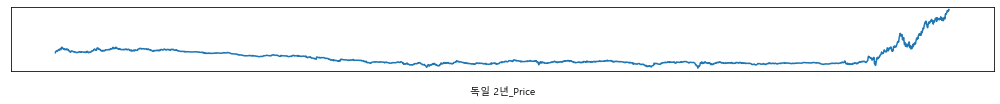

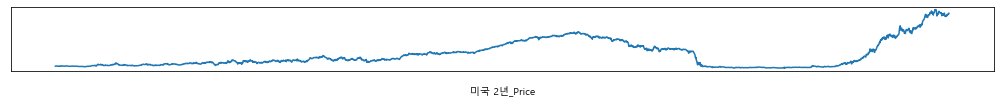

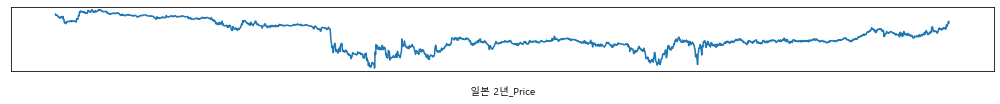

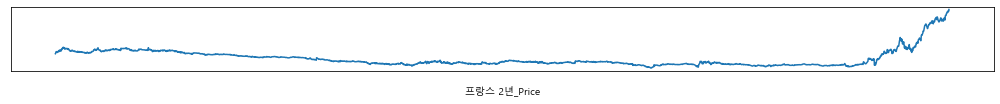

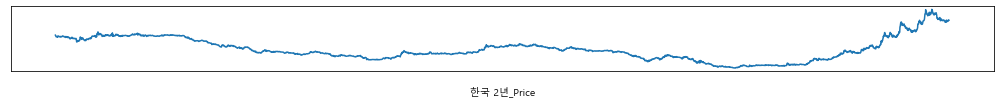

In [9]:
#국채금리
warnings.filterwarnings(action='ignore')
plt.rcParams['font.family'] = 'Malgun Gothic' # 한글 폰트

n = 1
for i in Treasury_rate:
    plt.figure(figsize=(14,8))
    plt.subplot(6,1,n)
    plt.plot(Total[[i]])
    plt.rc('axes', labelsize=10)
    plt.gca().axes.xaxis.set_ticks([])
    plt.gca().axes.yaxis.set_ticks([])
    plt.tight_layout(h_pad=3, w_pad=1)
    plt.xlabel(i, labelpad=15)
    n += 1

In [52]:
Total.to_csv('Total.csv', index = False)

## 변수 선택

- 모든 변수를 사용하는 것보다 적절하게 변수를 걸러내는 것이 성능을 더 높임
- 여러 조합의 변수로 예측해보았을 때 다른 경우보다 주가를 변수로 사용한 경우가 성능이 좋음 ==> 주가 변수의 조합으로 설명변수를 구성
- CNN, GRU, Linear, LSTM의 파라미터를 Gridsearch를 이용해 여러 조합으로 비교 ==> CNN이 가장 좋은 성과를 내어 모델을 CNN으로 결정

In [11]:
dir = r'C:\Users\whfhr\Desktop\신한 AI\사용data\Total.csv'

In [12]:
# 시드 고정
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [13]:
# Sequence generation and multi-step target creation
def generate_sequences(data, seq_length, n_steps):
    sequences_x = []
    sequences_y = []
    
    for i in range(len(data) - seq_length - n_steps + 1):
        sequences_x.append(data[i:i+seq_length, :])
        sequences_y.append(data[i+seq_length:i+seq_length+n_steps, 0])
    
    return np.array(sequences_x), np.array(sequences_y)

# CNN model definition
class CNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=3):
        super(CNNModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size),
            nn.ReLU(),
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.output_dim = output_dim

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = x.mean(2)
        x = self.fc(x)
        return x.view(-1, self.output_dim)

# Train function
def train(model, train_loader, loss_function, optimizer):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    return train_loss / len(train_loader)

# MAPE 계산을 위한 함수 정의
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-7  # 아주 작은 상수
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100


def test(model, test_loader, loss_function):
    model.eval()
    test_loss = 0.0
    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss += loss_function(outputs, targets).item()
            
            all_outputs.append(outputs.detach().numpy())
            all_targets.append(targets.detach().numpy())
            
    all_outputs = np.concatenate(all_outputs)
    all_targets = np.concatenate(all_targets)
    
    mse = mean_squared_error(all_targets, all_outputs)
    mae = mean_absolute_error(all_targets, all_outputs)
    mape = mean_absolute_percentage_error(all_targets, all_outputs)
    
    return test_loss / len(test_loader), mse, mae, mape

In [14]:
def optimal_parameters(columns):
    result = []
    for column in columns:
        data = Total
        # data = pd.read_csv(dir)
        data = data[column]

        seq_length = 30 # 입력 시퀀스
        n_steps = 60 # 출력 시퀀스 n_steps의 스텝을 에측.

        # 원본 데이터에서 끝의 n_steps개 데이터를 제외한 데이터에 대한 작업(data leakage를 완전 방지기 위함)
        # 이 원본 데이터의 n_steps개에 대한 예측을 진행하고, 시각적으로 비교.

        source_data = data
        data = source_data.head(len(data) - n_steps)

        # Data scaling
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(data)


        X, y = generate_sequences(scaled_data, seq_length, n_steps)

        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # PyTorch tensors and DataLoader
        train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
        test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

        train_loader = DataLoader(train_dataset, batch_size=128)
        test_loader = DataLoader(test_dataset, batch_size=128)

        seed_everything(42)
        input_dim = X_train.shape[2]
        hidden_dim = 64
        output_dim = y_train.shape[1]
        kernel_size = 3

        model = CNNModel(input_dim, hidden_dim, output_dim, kernel_size)

        # Loss function and optimizer
        loss_function = nn.MSELoss()
        optimizer = Adam(model.parameters(), lr=0.001)

        train_losses = []
        test_losses = []

        n_epochs = 20

        for epoch in range(n_epochs):
            train_loss = train(model, train_loader, loss_function, optimizer)
            test_metrics = test(model, test_loader, loss_function)  # test_metrics는 이제 튜플입니다.
            test_loss = test_metrics[0]  # test_loss는 튜플의 첫 번째 요소입니다.
            train_losses.append(train_loss)
            test_losses.append(test_loss)


        test_loss, mse, mae, mape = test(model, test_loader, loss_function)
        print(f"Final Test Loss: {test_loss:.6f} | MSE: {mse:.6f} | MAE: {mae:.6f} | MAPE: {mape:.6f}")

        # Prepare the last n_steps sequence from the test data
        last_sequence = pd.DataFrame(scaled_data).tail(seq_length).values

        # Predict the next n_steps
        next_n_steps_predictions = np.empty((n_steps, 1))
        for i in range(n_steps):
            next_step_prediction = model(torch.Tensor(last_sequence).unsqueeze(0)).detach().numpy()[:, 0]  # skip across feature dimensions
            next_n_steps_predictions[i, :] = next_step_prediction.reshape(-1, 1)

            # Change - Update last_sequence correctly considering dimensions
            last_sequence = np.roll(last_sequence, shift=-1, axis=0)
            last_sequence[-1, 0] = next_step_prediction

        # Inverse transformation
        next_n_steps_predictions_inverse = scaler.inverse_transform(
            np.hstack((next_n_steps_predictions, np.zeros((next_n_steps_predictions.shape[0], data.shape[1] - next_n_steps_predictions.shape[1]))))
        )[:, 0]
    
        result.append(dtw.distance(list(next_n_steps_predictions_inverse), list(source_data[column[0]].tail(n_steps))))
    return result

In [15]:
# 미국
data = Total
# data = pd.read_csv(dir)
stock = ['USA_SP500_Close', 'USA_NASDAQ_Close', 'USA_DOW_Close',"Korea_KOSPI_Close", "Korea_KOSDAQ_Close", "Korea_KOSPI200_Close"]
usd_columns = []

for i in range(len(stock)+1):
    for vari in combinations(stock, i):
        usd_columns.append(list(vari))
        
for i in range(len(usd_columns)):
    usd_columns[i] = ["KRWUSD_Close"] + usd_columns[i]
    
usd_result = optimal_parameters(usd_columns)

Final Test Loss: 0.011418 | MSE: 0.008524 | MAE: 0.066748 | MAPE: 123706.127930
Final Test Loss: 0.024660 | MSE: 0.019416 | MAE: 0.112555 | MAPE: 161499.121094
Final Test Loss: 0.021158 | MSE: 0.016754 | MAE: 0.106470 | MAPE: 149988.012695
Final Test Loss: 0.015484 | MSE: 0.011589 | MAE: 0.081264 | MAPE: 140178.564453
Final Test Loss: 0.033591 | MSE: 0.030029 | MAE: 0.158683 | MAPE: 151879.650879
Final Test Loss: 0.025336 | MSE: 0.021431 | MAE: 0.124647 | MAPE: 152365.478516
Final Test Loss: 0.033941 | MSE: 0.030509 | MAE: 0.161173 | MAPE: 150915.246582
Final Test Loss: 0.022782 | MSE: 0.017488 | MAE: 0.106348 | MAPE: 157560.717773
Final Test Loss: 0.020882 | MSE: 0.015589 | MAE: 0.094780 | MAPE: 155666.613770
Final Test Loss: 0.040873 | MSE: 0.035880 | MAE: 0.172334 | MAPE: 169929.968262
Final Test Loss: 0.023734 | MSE: 0.020130 | MAE: 0.122688 | MAPE: 145341.503906
Final Test Loss: 0.033763 | MSE: 0.029348 | MAE: 0.155922 | MAPE: 160377.648926
Final Test Loss: 0.022105 | MSE: 0.01747

In [16]:
# 일본
data = Total
# data = pd.read_csv(dir)
stock = ['Japan_JASDAQ20_Close', 'Japan_TOPIX_Close','Japan_NIKKEI_Close',"Korea_KOSPI_Close", "Korea_KOSDAQ_Close", "Korea_KOSPI200_Close"]
jpy_columns = []

for i in range(len(stock)+1):
    for vari in combinations(stock, i):
        jpy_columns.append(list(vari))
        
for i in range(len(jpy_columns)):
    jpy_columns[i] = ["KRWJPY_Close"] + jpy_columns[i]
    
jpy_result = optimal_parameters(jpy_columns)


Final Test Loss: 0.006758 | MSE: 0.007234 | MAE: 0.064812 | MAPE: 11.932576
Final Test Loss: 0.005734 | MSE: 0.006116 | MAE: 0.057526 | MAPE: 10.605960
Final Test Loss: 0.005779 | MSE: 0.006175 | MAE: 0.058963 | MAPE: 10.958885
Final Test Loss: 0.008048 | MSE: 0.008560 | MAE: 0.071593 | MAPE: 13.112429
Final Test Loss: 0.007381 | MSE: 0.007907 | MAE: 0.070106 | MAPE: 13.829093
Final Test Loss: 0.005909 | MSE: 0.006313 | MAE: 0.060664 | MAPE: 11.695962
Final Test Loss: 0.009960 | MSE: 0.010722 | MAE: 0.086289 | MAPE: 17.433523
Final Test Loss: 0.006410 | MSE: 0.006779 | MAE: 0.060974 | MAPE: 11.074895
Final Test Loss: 0.015868 | MSE: 0.016361 | MAE: 0.108490 | MAPE: 19.751406
Final Test Loss: 0.007507 | MSE: 0.008024 | MAE: 0.067623 | MAPE: 12.279537
Final Test Loss: 0.005994 | MSE: 0.006387 | MAE: 0.058365 | MAPE: 10.634899
Final Test Loss: 0.007965 | MSE: 0.008514 | MAE: 0.070497 | MAPE: 12.839687
Final Test Loss: 0.008317 | MSE: 0.008910 | MAE: 0.074149 | MAPE: 13.746867
Final Test L

In [17]:
# 영국
data = Total
# data = pd.read_csv(dir)
stock = ["UK_FTSE_Close", "UK_FTSE250_Close", "UK_FTSEALL_Close", "Korea_KOSPI_Close", "Korea_KOSDAQ_Close", "Korea_KOSPI200_Close"]
gbp_columns = []

for i in range(len(stock)+1):
    for vari in combinations(stock, i):
        gbp_columns.append(list(vari))
        
for i in range(len(gbp_columns)):
    gbp_columns[i] = ["KRWGBP_Close"] + gbp_columns[i]
    
gbp_result = optimal_parameters(gbp_columns)

Final Test Loss: 0.003369 | MSE: 0.003433 | MAE: 0.046879 | MAPE: 7.621884
Final Test Loss: 0.003355 | MSE: 0.003455 | MAE: 0.046224 | MAPE: 7.477813
Final Test Loss: 0.003212 | MSE: 0.003348 | MAE: 0.045781 | MAPE: 7.518521
Final Test Loss: 0.003417 | MSE: 0.003524 | MAE: 0.046246 | MAPE: 7.465520
Final Test Loss: 0.009052 | MSE: 0.009572 | MAE: 0.081510 | MAPE: 13.420646
Final Test Loss: 0.007169 | MSE: 0.007590 | MAE: 0.073561 | MAPE: 12.157635
Final Test Loss: 0.028654 | MSE: 0.030923 | MAE: 0.155791 | MAPE: 25.703508
Final Test Loss: 0.006195 | MSE: 0.006501 | MAE: 0.068250 | MAPE: 11.259567
Final Test Loss: 0.004049 | MSE: 0.004218 | MAE: 0.051891 | MAPE: 8.425478
Final Test Loss: 0.021381 | MSE: 0.023019 | MAE: 0.133991 | MAPE: 21.997599
Final Test Loss: 0.009513 | MSE: 0.010154 | MAE: 0.085463 | MAPE: 14.033854
Final Test Loss: 0.020585 | MSE: 0.022113 | MAE: 0.131149 | MAPE: 21.624753
Final Test Loss: 0.006493 | MSE: 0.006852 | MAE: 0.069641 | MAPE: 11.583316
Final Test Loss: 

In [18]:
# 유로존
data = Total
# data = pd.read_csv(dir)
stock = ["Euro_STOCKS50_Close", "Germany_MDAX_Close", "Germany_TecDAX_Close",  "France_CAC_Close", "Germany_DAX_Close", 'France_CACNEXT_Close',
       'France_SBF_Close',"Korea_KOSPI_Close", "Korea_KOSDAQ_Close", "Korea_KOSPI200_Close"]
eur_columns = []

for i in range(len(stock)+1):
    for vari in combinations(stock, i):
        eur_columns.append(list(vari))
        
for i in range(len(eur_columns)):
    eur_columns[i] = ["KRWEUR_Close"] + eur_columns[i]
    
eur_result = optimal_parameters(eur_columns)

Final Test Loss: 0.002536 | MSE: 0.002060 | MAE: 0.034858 | MAPE: 9.657142
Final Test Loss: 0.006521 | MSE: 0.006266 | MAE: 0.066254 | MAPE: 18.505439
Final Test Loss: 0.004320 | MSE: 0.003935 | MAE: 0.050555 | MAPE: 14.276510
Final Test Loss: 0.003324 | MSE: 0.003071 | MAE: 0.044255 | MAPE: 11.716133
Final Test Loss: 0.005111 | MSE: 0.004587 | MAE: 0.056240 | MAPE: 15.757817
Final Test Loss: 0.003681 | MSE: 0.003232 | MAE: 0.045679 | MAPE: 12.880830
Final Test Loss: 0.002957 | MSE: 0.002326 | MAE: 0.036485 | MAPE: 10.028396
Final Test Loss: 0.006021 | MSE: 0.005476 | MAE: 0.062861 | MAPE: 17.565140
Final Test Loss: 0.035980 | MSE: 0.038147 | MAE: 0.173509 | MAPE: 47.528720
Final Test Loss: 0.010331 | MSE: 0.010509 | MAE: 0.088062 | MAPE: 24.488965
Final Test Loss: 0.039485 | MSE: 0.041873 | MAE: 0.182784 | MAPE: 49.934009
Final Test Loss: 0.004841 | MSE: 0.004323 | MAE: 0.053895 | MAPE: 15.134671
Final Test Loss: 0.004353 | MSE: 0.003906 | MAE: 0.050903 | MAPE: 14.274195
Final Test Lo

- 시계열 데이터 비교에 좋은 DTW 방법으로 성능 비교

In [19]:
usd_result = pd.DataFrame(usd_result,columns = ["dtw"])
usd_result["stock"] = usd_columns
usd_result = usd_result.sort_values(by="dtw").reset_index(drop=True)

jpy_result = pd.DataFrame(jpy_result,columns = ["dtw"])
jpy_result["stock"] = jpy_columns
jpy_result = jpy_result.sort_values(by="dtw").reset_index(drop=True)

gbp_result = pd.DataFrame(gbp_result,columns = ["dtw"])
gbp_result["stock"] = gbp_columns
gbp_result = gbp_result.sort_values(by="dtw").reset_index(drop=True)

eur_result = pd.DataFrame(eur_result,columns = ["dtw"])
eur_result["stock"] = eur_columns
eur_result = eur_result.sort_values(by="dtw").reset_index(drop=True)

## 예측

In [20]:
# 예측
def prediction(country):
    data = Total
    # data = pd.read_csv(dir)
    data = data[sum(columns[country], [])]

    seq_length = 30 
    n_steps = 60 

    source_data = data
    data = source_data.head(len(data) - n_steps)

    # Data scaling
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X, y = generate_sequences(scaled_data, seq_length, n_steps)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # PyTorch tensors and DataLoader
    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=128)
    test_loader = DataLoader(test_dataset, batch_size=128)
    
    seed_everything(42)
    
    input_dim = X_train.shape[2]
    hidden_dim = 64
    output_dim = y_train.shape[1]
    kernel_size = 3

    model = CNNModel(input_dim, hidden_dim, output_dim, kernel_size)

    # Loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=0.001)

    train_losses = []
    test_losses = []

    n_epochs = 20

    for epoch in range(n_epochs):
        train_loss = train(model, train_loader, loss_function, optimizer)
        test_metrics = test(model, test_loader, loss_function)  # test_metrics는 이제 튜플입니다.
        test_loss = test_metrics[0]  # test_loss는 튜플의 첫 번째 요소입니다.
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
    test_loss, mse, mae, mape = test(model, test_loader, loss_function)

    # Prepare the last n_steps sequence from the test data
    last_sequence = pd.DataFrame(scaled_data).tail(seq_length).values

    # Predict the next n_steps
    next_n_steps_predictions = np.empty((n_steps, 1))
    for i in range(n_steps):
        next_step_prediction = model(torch.Tensor(last_sequence).unsqueeze(0)).detach().numpy()[:, 0]  # skip across feature dimensions
        next_n_steps_predictions[i, :] = next_step_prediction.reshape(-1, 1)

        # Change - Update last_sequence correctly considering dimensions
        last_sequence = np.roll(last_sequence, shift=-1, axis=0)
        last_sequence[-1, 0] = next_step_prediction

    # Inverse transformation
    next_n_steps_predictions_inverse = scaler.inverse_transform(
        np.hstack((next_n_steps_predictions, np.zeros((next_n_steps_predictions.shape[0], data.shape[1] - next_n_steps_predictions.shape[1]))))
    )[:, 0]
    return source_data[columns[country][0]].tail(n_steps+1).iloc[0], next_n_steps_predictions_inverse

# 예측 날짜
def prediction_date_func():
    n_steps = 60
    start = datetime.today().replace(month = 1, day=1)
    end = start + relativedelta(years=1)
    date = pd.date_range(start, periods=(end-start).days+1)

    week = []
    for i in date:
        if i.weekday() == 6 or i.weekday() == 5:
            week.append(i)
        else: pass
    
    holidays = pytimekr.holidays()

    date = list(map(lambda x: x.strftime("%Y-%m-%d"), date))
    week = list(map(lambda x: x.strftime("%Y-%m-%d"), week))
    holidays = list(map(lambda x: x.strftime("%Y-%m-%d"), holidays))

    date = list(set(date) - set(week))
    date = list(set(date) - set(holidays))
    date.sort()

    today = datetime.today().strftime("%Y-%m-%d")

    if today in date:
        prediction_date = date[date.index(today)+1:date.index(today)+n_steps+1]
    else:
        for i in date:
            if i > today:
                prediction_date = date[date.index(i):date.index(i)+n_steps]
                break
            else: pass
    return prediction_date

In [21]:
columns = {"미국" : [['KRWUSD_Close'],usd_result.iloc[0][1]],
          "일본" : [['KRWJPY_Close'],jpy_result.iloc[0][1]],
          "영국" : [['KRWGBP_Close'],gbp_result.iloc[0][1]],
          "유로존" : [['KRWEUR_Close'],eur_result.iloc[0][1]]}

In [49]:
# 서비스 1. 날짜 추천 서비스
def recommend_date(country):
    _, next_n_steps_predictions_inverse = prediction(country)
    prediction_date = prediction_date_func()
            
    next_n_steps_predictions_inverse = list(next_n_steps_predictions_inverse)
    minidx = next_n_steps_predictions_inverse.index(min(next_n_steps_predictions_inverse))
    
    return prediction_date[minidx]

def recommend_date_result():
    prediction_date = prediction_date_func()
    print("(2022년 데이터를 기준으로 미래를 예측. 실제 서비스 적용시, 현재부터 과거 데이터를 적용해야 함)")
    print("\n{} ~ {} 기간 내에 지정하신 국가의 환율이 낮은 날을 추천을 해드립니다.".format(prediction_date[0],prediction_date[-1]))
    print("미국, 일본, 유로존, 영국 중 여행을 떠날 나라를 지정해주세요.")
    country = input()
    
    if country in ["미국", "일본", "영국", "유로존"]:
        date = recommend_date(country)
        print("\n{} ~ {} 중 {} 환율이 낮은 날은 {}(+-2일) 부근입니다.".format(prediction_date[0],prediction_date[-1],country,date))
    else:
        print("\n국가를 다시 확인해주세요.\n")
        recommend_date_result()
recommend_date_result()


(2022년 데이터를 기준으로 미래를 예측. 실제 서비스 적용시, 현재부터 과거 데이터를 적용해야 함)

2023-07-12 ~ 2023-10-10 기간 내에 지정하신 국가의 환율이 낮은 날을 추천을 해드립니다.
미국, 일본, 유로존, 영국 중 여행을 떠날 나라를 지정해주세요.

2023-07-12 ~ 2023-10-10 중 미국 환율이 낮은 날은 2023-07-18(+-2일) 부근입니다.


In [50]:
# 서비스 2. 국가 추천 서비스
def recommend_country():
    today_usd, USD = list(prediction("미국"))
    today_jpy, JPY = list(prediction("일본"))
    today_gbp, GBP = list(prediction("영국"))
    today_eur, EUR = list(prediction("유로존"))
    
    prediction_date = prediction_date_func()
    
    enc_usd = (list(USD)/today_usd.values[0]*100)
    enc_jpy = (list(JPY)/today_jpy.values[0]*100)
    enc_gbp = (list(GBP)/today_gbp.values[0]*100)
    enc_eur = (list(EUR)/today_eur.values[0]*100)
    
    min_value = [min(enc_usd),min(enc_jpy),min(enc_gbp),min(enc_eur)]
    min_idx = min_value.index(min(min_value))
    enchage = [enc_usd, enc_jpy, enc_gbp, enc_eur]
    
    idx = list(enchage[min_idx]).index(min(enchage[min_idx]))
    
    country = ["미국", "일본", "영국", "유로존"]
    
    return country[min_idx], prediction_date[idx]

def recommend_country_result():
    prediction_date = prediction_date_func()
    print("(2022년 데이터를 기준으로 미래를 예측. 실제 서비스 적용시, 현재부터 과거 데이터를 적용해야 함)")
    print("\n미국, 일본, 유로존, 영국 중 추천을 해드리겠습니다.")
    country, date = recommend_country()
    print("\n오늘 대비 환율이 가장 낮은 나라는 {} 이고, {}(+-2일) 부근입니다.".format(country, date))
    
recommend_country_result()

(2022년 데이터를 기준으로 미래를 예측. 실제 서비스 적용시, 현재부터 과거 데이터를 적용해야 함)

미국, 일본, 유로존, 영국 중 추천을 해드리겠습니다.

오늘 대비 환율이 가장 낮은 나라는 일본 이고, 2023-07-12(+-2일) 부근입니다.
